In [ ]:
!pip install catboost
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter
import datetime
import optuna

In [ ]:
train_path='train.csv'
val_path='val.csv'
train_raw = pd.read_csv(train_path)
val_raw =pd.read_csv(val_path)

In [ ]:
class logBudgetImputer:
    def __init__(self):
        # The MICE Imputer (The "Brain")
        self.imputer = IterativeImputer(max_iter=20, random_state=42)

        self.country_encoder = OrdinalEncoder()
        self.genre_encoder = OrdinalEncoder()
        self.company_encoder = OrdinalEncoder()
        # Store medians for fallback safety
        self.defaults = {}
        self.feature_cols = [
            'release_year', 'runtime', 'average_actor_score',
            'top_actor_score', 'encoded_genre','encoded_company',
            'director_score', 'encoded_country', 'log_budget'
        ]

    def _prepare_matrix(self, df, fit_mode=False):
        """
        Internal helper to format the matrix for the imputer.
        Does NOT modify the original dataframe.
        """
        df_temp = df.copy()

        # Extract Year
        df_temp['release_year'] = pd.to_datetime(
            df_temp['release_date'], errors='coerce'
        ).dt.year
        # Extract main genre, main production company
        df_temp['main_genre'] = df_temp['genres'].str.split(',').str[0]
        df_temp['main_production_company'] = df_temp['production_companies'].str.split(',').str[0]

        if fit_mode:
            self.country_encoder.fit(df_temp[['main_production_country']])
            self.genre_encoder.fit(df_temp[['main_genre']])
            self.company_encoder.fit(df_temp[['main_production_company']])
        # Label encode , unseen value = 'Missing value'
        known_countries = set(self.country_encoder.categories_[0])
        df_temp.loc[~df_temp['main_production_country'].isin(known_countries), 'main_production_country'] = 'Missing value'
        df_temp['encoded_country'] = self.country_encoder.transform(
            df_temp[['main_production_country']]
        )
        known_genres = set(self.genre_encoder.categories_[0])
        df_temp.loc[~df_temp['main_genre'].isin(known_genres), 'main_genre'] = 'Missing value'
        df_temp['encoded_genre'] = self.genre_encoder.transform(
            df_temp[['main_genre']]
        )
        known_companies = set(self.company_encoder.categories_[0])
        df_temp.loc[~df_temp['main_production_company'].isin(known_companies), 'main_production_company'] = 'Missing value'
        df_temp['encoded_company'] = self.company_encoder.transform(
            df_temp[['main_production_company']]
        )

        return df_temp[self.feature_cols]

    def fit(self, train_df):
        """
        Learns the relationship between Budget and other features
        ONLY from the training set.
        """
        print("Fitting BudgetImputer on training data...")

        # Prepare the numeric matrix
        X_train = self._prepare_matrix(train_df, fit_mode=True)

        # Train the MICE model
        self.imputer.fit(X_train)
        print("Imputer successfully fitted.")
        return self

    def transform(self, df):
        """
        Applies the learned logic to any dataset (Train, Val, or Test).
        """
        df_out = df.copy()
        df_out['is_budget_missing'] = df_out['budget'].isna().astype(int)

        # 1. Prepare data (using the encoders/medians learned in fit)
        X_matrix = self._prepare_matrix(df_out, fit_mode=False)

        # 2. Predict Missing Budgets
        # transform returns a numpy array, we care about the last column ('budget')
        imputed_matrix = self.imputer.transform(X_matrix)
        predicted_budgets = imputed_matrix[:, -1] # The last column is budget

        # 3. Fill NaN values in the original dataframe
        # We use a temporary Series to align the index correctly
        fill_values = pd.Series(predicted_budgets, index=df_out.index)

        # Only overwrite MISSING values. Trust the real data if it exists.
        df_out['log_budget'] = df_out['log_budget'].fillna(fill_values)

        return df_out

In [ ]:
class GenreOneHotEncoder:
    def __init__(self, genre_col='genres', prefix='genre_'):
        self.genre_col = genre_col
        self.prefix = prefix
        self.mlb = MultiLabelBinarizer()
        self.fitted = False

    def _prepare_series(self, df):
        """
        Helper: Cleans the column and splits "Action, Comedy" into ["Action", "Comedy"]
        """
        return df[self.genre_col].fillna('Missing value').astype(str).str.split(', ')

    def fit(self, train_df):
        """
        Learns all possible unique genres from the training set.
        """
        genre_lists = self._prepare_series(train_df)
        self.mlb.fit(genre_lists)
        self.fitted = True

        print(f"Learned {len(self.mlb.classes_)} unique genres: {self.mlb.classes_}")
        return self

    def transform(self, df):
        """
        Creates new binary columns (e.g., g_Action, g_Comedy) and joins them to the DF.
        """
        if not self.fitted:
            raise ValueError("You must call .fit(train_df) before .transform()!")

        df_out = df.copy()

        # 1. Get the lists of genres for the current dataframe
        genre_lists = self._prepare_series(df_out)

        # 2. Transform into a binary matrix (0s and 1s)
        # Note: Scikit-learn ignores unseen labels in transform automatically (safe for test set)
        binary_matrix = self.mlb.transform(genre_lists)

        # 3. Create a DataFrame with proper column names
        # We add a prefix (e.g. "g_") to avoid colliding with other columns
        new_cols = [f"{self.prefix}{cls}" for cls in self.mlb.classes_]
        genre_df = pd.DataFrame(binary_matrix, columns=new_cols, index=df_out.index)

        # 4. Concatenate with original data
        df_out = pd.concat([df_out, genre_df], axis=1)

        return df_out

In [ ]:
class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, col, min_freq=50, other_value='Other'):
        self.col = col
        self.min_freq = min_freq
        self.other_value = other_value
        self.valid_categories = None

    def fit(self, X, y=None):
        """
        Learns which categories are 'common' ONLY from the Training set.
        """
        counts = X[self.col].value_counts()

        # We only keep categories that appear >= min_freq times
        self.valid_categories = set(counts[counts >= self.min_freq].index)

        print(f"Learned {len(self.valid_categories)} valid categories for '{self.col}'")
        return self

    def transform(self, X):
        """
        Applies the Safe List to ANY dataset (Train, Val, or Test).
        """
        if self.valid_categories is None:
            raise ValueError("You must fit the encoder on training data first!")

        X_out = X.copy()

        #If you are not on the train list, you are 'Other'
        mask = X_out[self.col].isin(self.valid_categories)
        X_out[self.col] = X_out[self.col].where(mask, self.other_value)

        return X_out

In [ ]:
class MaxFrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, col='production_companies', separator=','):
        self.col = col
        self.separator = separator
        self.global_counts = {}

    def fit(self, X, y=None):
        """
        Learns the global frequency of every individual company from the training set.
        """

        all_companies = (
            X[self.col]
            .fillna('')
            .astype(str)
            .str.split(self.separator)
            .explode()
        )

        self.global_counts = Counter(c for c in all_companies if c != '')

        print(f"Learned frequencies for {len(self.global_counts)} unique companies.")
        return self

    def transform(self, X):
        """
        For each row, finds the company with the highest global frequency
        and returns that count.
        """
        if not self.global_counts:
            raise ValueError("You must fit the encoder on training data first!")

        def get_max_freq(row_str):
            if pd.isna(row_str) or row_str == '':
                return 0

            companies = str(row_str).split(self.separator)


            counts = [self.global_counts.get(c, 0) for c in companies]

            return max(counts) if counts else 0

        X_out = X.copy()

        new_col_name = f"{self.col}_max_freq"
        X_out[new_col_name] = X_out[self.col].apply(get_max_freq)


        return X_out

In [ ]:
def df_split_dates(df,colname = 'release_date'):
    df["release_year"] = df[colname].dt.year
    df["release_month"] = df[colname].dt.month
    df["release_day"] = df[colname].dt.day
    df["release_dayofweek"] = df[colname].dt.dayofweek
    df["release_dayofyear"] = df[colname].dt.dayofyear
    df['release_time'] = df[colname].astype(np.int64)
    df['month_sin'] = np.sin(2 * np.pi * df['release_month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['release_month'] / 12)
    df['dow_sin'] = np.sin(2 * np.pi * df['release_dayofweek'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['release_dayofweek'] / 7)

In [ ]:
def clean_data(df):
    df = df.copy()
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    return df
def preprocess_data_train(df):
    df = df.copy()

    df['log_budget'] = np.log1p(df['budget'])
    df['log_revenue'] = np.log1p(df['revenue'])

    #Date feature engineering
    df_split_dates(df)

    #One hot encode genre
    genre_encoder = GenreOneHotEncoder()
    genre_encoder.fit(df)
    df = genre_encoder.transform(df)

    #Group production country
    country_encoder = RareCategoryGrouper(col='main_production_country', min_freq=50)
    country_encoder.fit(df)
    df = country_encoder.transform(df)

    #Group original language
    language_encoder = RareCategoryGrouper(col='original_language', min_freq=50)
    language_encoder.fit(df)
    df = language_encoder.transform(df)

    #Frequency encode production company
    company_encoder = MaxFrequencyEncoder()
    company_encoder.fit(df)
    df = company_encoder.transform(df)


    #Fill missing budget
    budgetImputer = logBudgetImputer()
    budgetImputer.fit(df)
    df = budgetImputer.transform(df)


    #Add additonal features
    df['_budget_year_ratio'] = df['budget']/(df['release_year']*df['release_year'])
    df['_director_time_actor_score'] = df['average_actor_score'] * df['director_score']
    df['_budget_runtime_ratio'] = df['budget']/df['runtime']
    return df,budgetImputer,genre_encoder,country_encoder,language_encoder, company_encoder
def preprocess_data_test(df, budgetImputer,genre_encoder,country_encoder,language_encoder,company_encoder ):
    df = df.copy()

    df['log_budget'] = np.log1p(df['budget'])
    df['log_revenue'] = np.log1p(df['revenue'])

    #Date feature engineering
    df_split_dates(df)

    #One hot encode genre
    df = genre_encoder.transform(df)

    #Group production country
    df = country_encoder.transform(df)

    #Group original language
    df = language_encoder.transform(df)

    #Frequency encode production company
    df = company_encoder.transform(df)




    #Fill missing budget
    df = budgetImputer.transform(df)


    #Add additonal features
    df['_budget_year_ratio'] = df['budget']/(df['release_year']*df['release_year'])
    df['_director_time_actor_score'] = df['average_actor_score'] * df['director_score']
    df['_budget_runtime_ratio'] = df['budget']/df['runtime']
    return df

In [ ]:
def train_model_on_training_data(train_df, val_df, IGNORE_COLS, TARGET_COL, TEXT_COLS=None):
    """
    TEXT_COLS: List of column names to treat as raw text (BoW/Tokenization)
               instead of categorical (One-Hot/Target Encoding).
    """
    if TEXT_COLS is None:
        TEXT_COLS = []

    features = [col for col in train_df.columns if col not in IGNORE_COLS]


    cat_candidates = train_df[features].select_dtypes(include=['object', 'category']).columns.tolist()
    cat_features = [col for col in cat_candidates if col not in TEXT_COLS]

    text_features = [col for col in TEXT_COLS if col in features]

    cat_indices = [features.index(c) for c in cat_features]
    text_indices = [features.index(c) for c in text_features]

    print(f"Training features: {features}")
    print(f"Categorical features (Target Encoded): {cat_features}")
    print(f"Text features (Tokenized/BoW): {text_features}")

    train_pool = Pool(
        train_df[features],
        train_df[TARGET_COL],
        cat_features=cat_indices,
        text_features=text_indices,
    )
    val_pool = Pool(
        val_df[features],
        val_df[TARGET_COL],
        cat_features=cat_indices,
        text_features=text_indices
    )

    model = CatBoostRegressor(
        iterations=2000,
        learning_rate=0.05,
        depth=8,
        loss_function='RMSE',
        eval_metric='RMSE',
        custom_metric=['R2'],
        random_seed=42,
        early_stopping_rounds=50,
        verbose=200,


        tokenizers=[{
            'tokenizer_id': 'Comma',
            'separator_type': 'ByDelimiter',
            'delimiter': ','
        }],
        dictionaries=[{
            'dictionary_id': 'Word',
            'max_dictionary_size': '50000'
        }],
        feature_calcers=[
            'BoW:top_tokens_count=2000'
        ]
    )

    model.fit(train_pool, eval_set=val_pool, use_best_model=True)

    return model, features

In [ ]:
def plot_feature_importance(model, features, top_n=20):
    """
    Plots a horizontal bar chart of the top N most important features.
    Returns the full sorted dataframe.
    """
    # 1. Create DataFrame
    importance = model.get_feature_importance()
    fi_df = pd.DataFrame({'Feature': features, 'Importance': importance})

    # 2. Sort Descending (Highest importance first)
    fi_df = fi_df.sort_values(by='Importance', ascending=False)

    # 3. Prepare data for plotting
    # We take the top N, then reverse it (sort ascending) so the
    # most important feature appears at the TOP of the horizontal chart.
    plot_df = fi_df.head(top_n).sort_values(by='Importance', ascending=True)

    # 4. Plot
    plt.figure(figsize=(10, len(plot_df) * 0.4 + 2)) # Adjust height dynamically based on N
    plt.barh(plot_df['Feature'], plot_df['Importance'], color='#1f77b4')

    plt.title(f'Top {len(plot_df)} Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout() # Ensures labels are not cut off
    plt.show()

    return fi_df
def evaluate_model_performance(model, val_df, features,target_col = 'revenue', bias = 0):
    """
    Model must have output as log1p(revenue)
    Data must have log_revenue and log_budget column
    Print evaluation metrics
    """
    log_preds = model.predict(val_df[features])
    log_actuals = val_df[f'log_{target_col}']

    real_preds = np.expm1(log_preds)
    real_actuals = np.expm1(log_actuals)

    # --- 2. Calculate Metrics ---

    # Log-Space Metrics (Technical Performance)
    log_rmse = np.sqrt(mean_squared_error(log_actuals, log_preds))
    log_r2 = r2_score(log_actuals, log_preds)

    # Real-Dollar Metrics (Business Performance)
    real_mae = mean_absolute_error(real_actuals, real_preds)
    real_r2 = r2_score(real_actuals, real_preds)


    #intercept shift
    if bias == 0:
      bias = np.mean(val_df['log_revenue']) - np.mean(log_preds)
    calibrated_preds = log_preds + bias
    new_rmsle = np.sqrt(mean_squared_error(log_actuals, calibrated_preds))
    new_r2_log =  r2_score(log_actuals, calibrated_preds)
    new_mae = mean_absolute_error(np.expm1(log_actuals), np.expm1(calibrated_preds))
    new_r2_real = r2_score(np.expm1(log_actuals), np.expm1(calibrated_preds))
    print("==========================================")
    print("            PERFORMANCE REPORT            ")
    print("==========================================")
    print(f"Technical (Log-Space):")
    print(f"  RMSE (Log):      {log_rmse:.4f}")
    print(f"  R² (Log):        {log_r2:.4f}")
    print("-" * 40)
    print(f"Business (Real Dollars):")
    print(f"  MAE ($):         ${real_mae:,.2f}")
    print(f"  R² (Real):       {real_r2:.4f}")
    print(f"Testing using intercept shift:")
    print(f"Systematic Bias: {bias:.4f}")
    print(f"Calibrated RMSLE: {new_rmsle:.4f}")
    print(f"Calibrated R² (Log): {new_r2_log:.4f}")
    print(f"Calibrated MAE ($): ${new_mae:,.2f}")
    print(f"Calibrated R² (Real): {new_r2_real:.4f}")
    # --- 3. Evaluate Tree Complexity ---

    print("\n==========================================")
    print("           MODEL COMPLEXITY               ")
    print("==========================================")

    tree_count = model.tree_count_
    print(f"Total Trees Built:   {tree_count}")


    return real_preds,bias

In [ ]:
train_df = clean_data(train_raw)
val_df = clean_data(val_raw)
train_df,budgetImputer,genreEncoder, countryGrouper, languageGrouper, companyEncoder = preprocess_data_train(train_df)
val_df = preprocess_data_test(val_df,budgetImputer,genreEncoder,countryGrouper, languageGrouper,companyEncoder)

Learned 19 unique genres: ['Action' 'Adventure' 'Animation' 'Comedy' 'Crime' 'Drama' 'Family'
 'Fantasy' 'History' 'Horror' 'Missing value' 'Music' 'Mystery' 'Romance'
 'Science Fiction' 'TV Movie' 'Thriller' 'War' 'Western']
Learned 51 valid categories for 'main_production_country'
Learned 40 valid categories for 'original_language'
Learned frequencies for 27659 unique companies.
Fitting BudgetImputer on training data...
Imputer successfully fitted.


In [ ]:
pd.set_option('display.max_columns', None)
train_df.head()

,imdb_id,tmdb_id,title,release_date,runtime,genres,director,top_cast,original_language,production_companies,budget,revenue,actor_1_score,actor_2_score,actor_3_score,actor_4_score,actor_5_score,director_score,average_actor_score,top_actor_score,number_of_actors,main_production_country,log_budget,log_revenue,release_year,release_month,release_day,release_dayofweek,release_dayofyear,release_time,month_sin,month_cos,dow_sin,dow_cos,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Drama,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Missing value,genre_Music,genre_Mystery,genre_Romance,genre_Science Fiction,genre_TV Movie,genre_Thriller,genre_War,genre_Western,production_companies_max_freq,is_budget_missing,_budget_year_ratio,_director_time_actor_score,_budget_runtime_ratio
0,tt0067606,117213,Preacherman,1971-01-01,87.0,"Drama, Comedy",Albert T. Viola,"Albert T. Viola, Ilene Kristen, Adam Hesse, Ma...",en,Albert T. Viola Productions,65000.0,5000000,5,0,0,1,1,5,1.4,5,5,United States of America,11.082158,15.424949,1971,1,1,4,1,31536000000000000,0.500000,0.866025,-0.433884,-0.900969,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.016732,7.0,747.126437
1,tt0067927,11951,Vanishing Point,1971-01-15,99.0,"Action, Crime, Drama, Thriller",Richard C. Sarafian,"Barry Newman, Cleavon Little, Dean Jagger, Vic...",en,"Cupid Productions, 20th Century Fox",1300000.0,72266306,2,8,97,1,11,37,23.8,97,5,United States of America,14.077876,18.095869,1971,1,15,4,15,32745600000000000,0.500000,0.866025,-0.433884,-0.900969,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,300,0,0.334634,880.6,13131.313131
2,tt0066819,31906,The Beguiled,1971-01-23,105.0,"Thriller, Drama, War",Don Siegel,"Clint Eastwood, Geraldine Page, Elizabeth Hart...",en,"Malpaso Productions, Universal Pictures",475000.0,1100000,6,18,39,7,46,58,23.2,46,5,United States of America,13.071072,13.910822,1971,1,23,5,23,33436800000000000,0.500000,0.866025,-0.974928,-0.222521,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,275,0,0.122270,1345.6,4523.809524
3,tt0067128,1485,Get Carter,1971-02-03,112.0,"Crime, Thriller",Mike Hodges,"Michael Caine, Ian Hendry, Britt Ekland, John ...",en,"Metro-Goldwyn-Mayer, Metro-Goldwyn-Mayer Briti...",1814462.0,60404,13,17,35,25,66,12,31.2,66,5,United Kingdom,14.411300,11.008827,1971,2,3,2,34,34387200000000000,0.866025,0.500000,0.974928,-0.222521,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,88,0,0.467062,374.4,16200.553571
4,tt0065761,27431,The Cat o' Nine Tails,1971-02-12,112.0,"Horror, Mystery, Thriller",Dario Argento,"James Franciscus, Karl Malden, Catherine Spaak...",it,"Labrador Films, Seda Spettacoli, Terra-Filmkun...",1000000.0,1204739,47,32,84,43,20,17,45.2,84,5,Germany,13.815512,14.001774,1971,2,12,4,43,35164800000000000,0.866025,0.500000,-0.433884,-0.900969,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,3,0,0.257411,768.4,8928.571429


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29954 entries, 0 to 29953
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   imdb_id                        29954 non-null  object        
 1   tmdb_id                        29954 non-null  int64         
 2   title                          29954 non-null  object        
 3   release_date                   29954 non-null  datetime64[ns]
 4   runtime                        29954 non-null  float64       
 5   genres                         29954 non-null  object        
 6   director                       29954 non-null  object        
 7   top_cast                       29954 non-null  object        
 8   original_language              29954 non-null  object        
 9   production_companies           29954 non-null  object        
 10  budget                         10877 non-null  float64       
 11  revenue        

In [ ]:
TARGET = 'log_revenue'
IGNORE_COLS = ['imdb_id', 'tmdb_id', 'title', 'release_date', 'genres','top_cast','production_companies','budget','revenue',TARGET]
TEXT_FEATURES = []

Training features: ['runtime', 'director', 'original_language', 'actor_1_score', 'actor_2_score', 'actor_3_score', 'actor_4_score', 'actor_5_score', 'director_score', 'average_actor_score', 'top_actor_score', 'number_of_actors', 'main_production_country', 'log_budget', 'release_year', 'release_month', 'release_day', 'release_dayofweek', 'release_dayofyear', 'release_time', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Missing value', 'genre_Music', 'genre_Mystery', 'genre_Romance', 'genre_Science Fiction', 'genre_TV Movie', 'genre_Thriller', 'genre_War', 'genre_Western', 'production_companies_max_freq', 'is_budget_missing', '_budget_year_ratio', '_director_time_actor_score', '_budget_runtime_ratio']
Categorical features (Target Encoded): ['director', 'original_language', 'main_production_country']
Text features (T

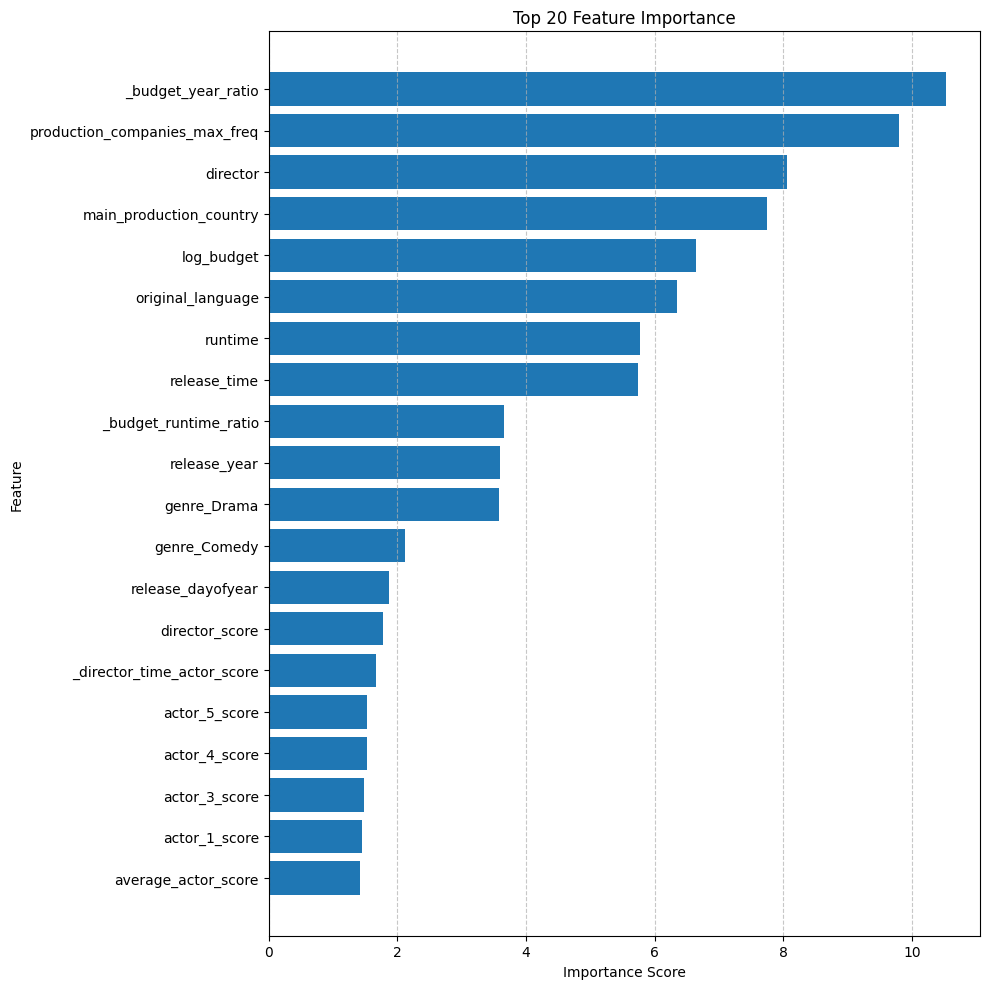

,Feature,Importance
45,_budget_year_ratio,10.534149
43,production_companies_max_freq,9.796029
1,director,8.056351
12,main_production_country,7.743603
13,log_budget,6.638201
2,original_language,6.354420
0,runtime,5.780038
19,release_time,5.750753
47,_budget_runtime_ratio,3.664754
14,release_year,3.596299


In [ ]:
model, features = train_model_on_training_data(train_df, val_df, IGNORE_COLS, TARGET,TEXT_FEATURES)
preds, production_bias = evaluate_model_performance(model, val_df, features)
plot_feature_importance(model,features, 20)

# Iteration logs:

## Baseline (No categorical columns, log transform on budget and revenue)
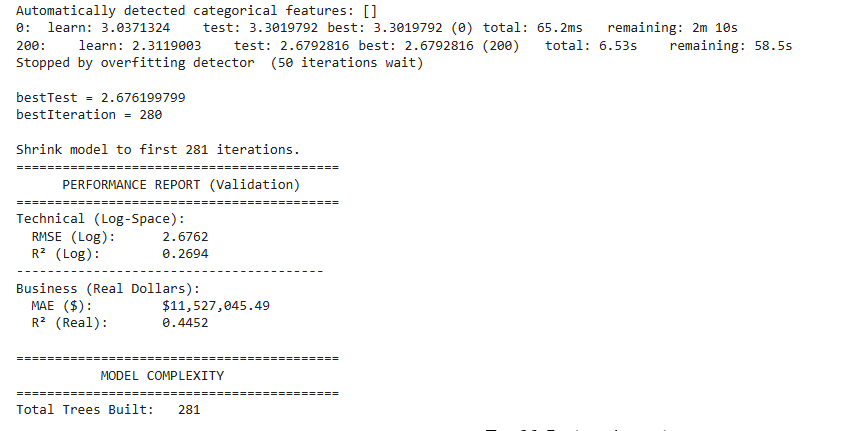

## Using MICE to impute budget (small increase)
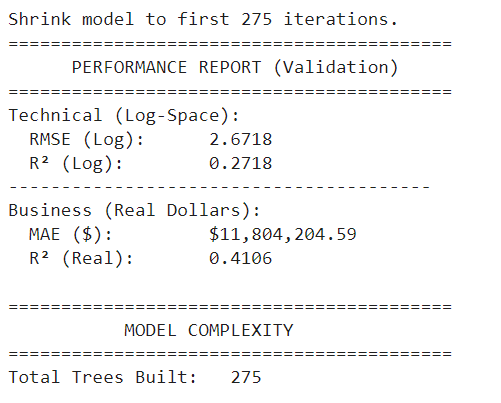

## One hot encoding on genre (Big increase)
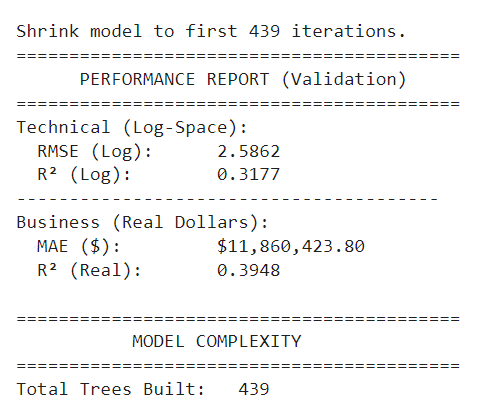

## Adding feature engineered release_date (big increase)
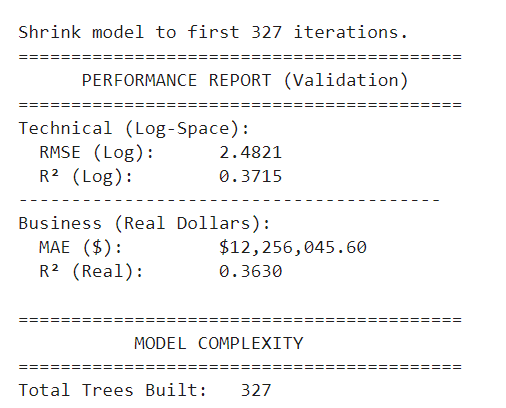

## Adding production country and language after grouping method (big increase)
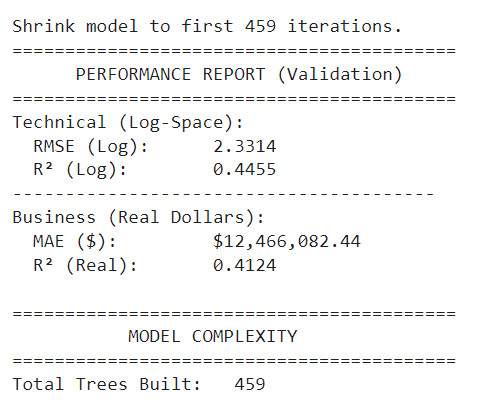


## Adding frequency encoded production company
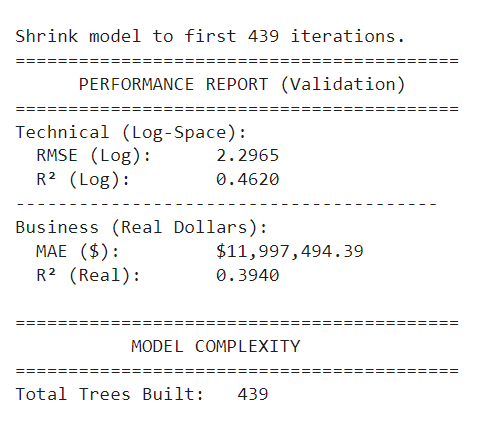

## Adding director, using built in target encoding of catboost
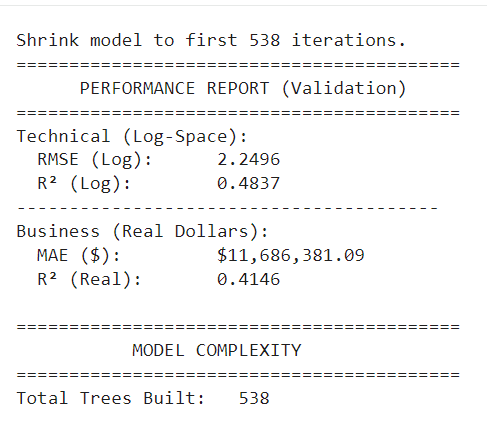

## Adding budget accounted for inflation (no increase in performance)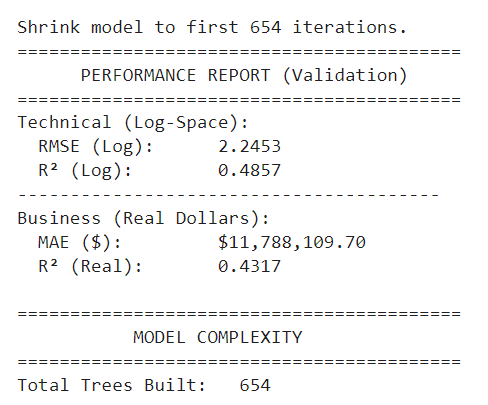

## Adding new engineered features (small increase)


```
df['_budget_runtime_ratio'] = df['budget']/df['runtime']
df['_budget_year_ratio'] = df['budget']/(df['release_year']*df['release_year'])
df['_director_time_actor_score'] = df['average_actor_score'] * df['director_score']
```

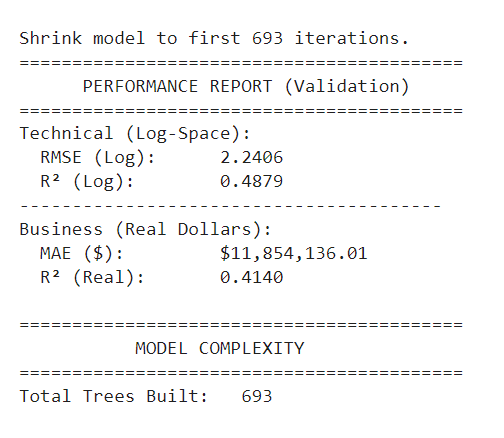

## Try optuna for parameter tuning
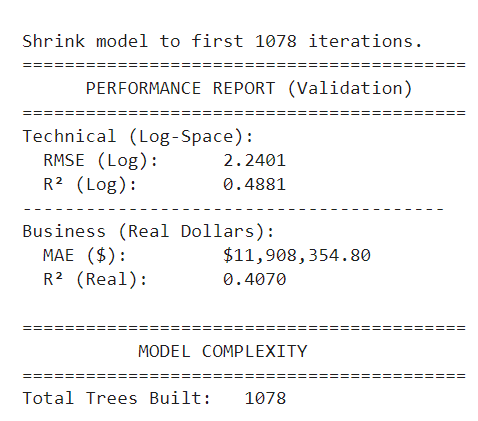

## Intercept shifting
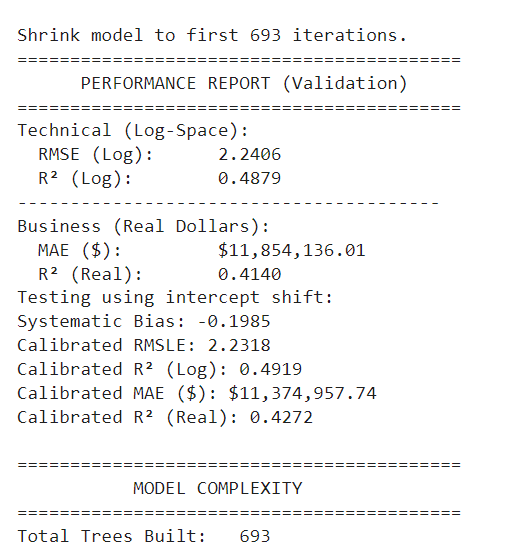

# Final test on test set

In [ ]:
test_df = pd.read_csv("test.csv")
test_df = clean_data(test_df)
test_df = preprocess_data_test(test_df,budgetImputer,genreEncoder,countryGrouper, languageGrouper,companyEncoder)
evaluate_model_performance(model, test_df,features,bias = production_bias)

            PERFORMANCE REPORT            
Technical (Log-Space):
  RMSE (Log):      2.1956
  R² (Log):        0.4858
----------------------------------------
Business (Real Dollars):
  MAE ($):         $10,694,053.47
  R² (Real):       0.5298
Testing using intercept shift:
Systematic Bias: -0.1985
Calibrated RMSLE: 2.1882
Calibrated R² (Log): 0.4892
Calibrated MAE ($): $10,215,837.78
Calibrated R² (Real): 0.5458

           MODEL COMPLEXITY               
Total Trees Built:   693


(array([  64333.72212248,  218369.42929405,   10911.89769176, ...,
         465930.63391712,  154112.94589722, 1086455.0734262 ]),
 np.float64(-0.19848664513631142))

# Export the model

In [ ]:
class ManualPipelinePredictor:
    def __init__(self, model,features,bias, encoders):
        self.model = model
        self.bias = bias
        self.encoders = encoders
        self.features = features
        self.required_raw_cols = [
            'budget',
            'release_date',
            'runtime',
            'genres',
            'main_production_country',
            'original_language',
            'production_companies',
            'average_actor_score',
            'director',
            'director_score',
            'actor_1_score',
            'actor_2_score',
            'actor_3_score',
            'actor_4_score',
            'actor_5_score',
            'top_actor_score',
            'number_of_actors'
        ]
    def df_split_dates(self,df,colname = 'release_date'):
        df["release_year"] = df[colname].dt.year
        df["release_month"] = df[colname].dt.month
        df["release_day"] = df[colname].dt.day
        df["release_dayofweek"] = df[colname].dt.dayofweek
        df["release_dayofyear"] = df[colname].dt.dayofyear
        df['release_time'] = df[colname].astype(np.int64)
        df['month_sin'] = np.sin(2 * np.pi * df['release_month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['release_month'] / 12)
        df['dow_sin'] = np.sin(2 * np.pi * df['release_dayofweek'] / 7)
        df['dow_cos'] = np.cos(2 * np.pi * df['release_dayofweek'] / 7)

    def _validate_input(self, df):
        """Checks if the user provided all necessary raw columns."""
        missing = [col for col in self.required_raw_cols if col not in df.columns]

        if missing:
            raise ValueError(f"Input data is missing required columns: {missing}")

        if df['release_date'].isnull().any():
             raise ValueError("Input data contains NULL/NaN in 'budget' column.")

    def preprocess(self, df):
        self._validate_input(df)
        df = df.copy()
        df['release_date'] = pd.to_datetime(df['release_date'])

        #Budget log
        df['log_budget'] = np.log1p(df['budget'])

        #Date feature engineering
        self.df_split_dates(df)

        #One hot encode genre
        df = self.encoders['genre'].transform(df)

        #Group production country
        df = self.encoders['country'].transform(df)

        #Group original language
        df = self.encoders['language'].transform(df)

        #Frequency encode production company
        df = self.encoders['company'].transform(df)

        #Fill missing budget
        df = self.encoders['log_budget_imputer'].transform(df)


        #Add additonal features
        df['_budget_year_ratio'] = df['budget']/(df['release_year']*df['release_year'])
        df['_director_time_actor_score'] = df['average_actor_score'] * df['director_score']
        df['_budget_runtime_ratio'] = df['budget']/df['runtime']



        df = df[self.features]
        return df

    def predict(self, new_data):
        processed_df = self.preprocess(new_data)
        log_pred = self.model.predict(processed_df)
        final_pred = np.expm1(log_pred + self.bias)

        return final_pred

In [ ]:
import joblib
my_encoders = {
    'log_budget_imputer': budgetImputer,
    'genre': genreEncoder,
    'country': countryGrouper,
    'language': languageGrouper,
    'company': companyEncoder
}
final_predictor = ManualPipelinePredictor(
    model=model,
    features=features,
    bias=production_bias,
    encoders=my_encoders
)
joblib.dump(final_predictor, 'movie_revenue_catboost_model.pkl')

['movie_revenue_catboost_model.pkl']

In [ ]:
MODEL_FILENAME = 'movie_revenue_catboost_model.pkl'
try:
    print(f"Loading {MODEL_FILENAME}...")
    predictor = joblib.load(MODEL_FILENAME)
    print("✅ Model loaded successfully!")
except FileNotFoundError:
    print(f"❌ Error: Could not find file '{MODEL_FILENAME}'. Make sure it is in this folder.")
    exit()
except AttributeError as e:
    print(f"❌ Error: Missing Class Definition. Did you paste your Encoder classes in Part 1?\nDetails: {e}")
    exit()

# 2. Create Dummy Data (A Fake Blockbuster)
# This matches the 'required_raw_cols' list exactly
test_data = pd.DataFrame([{
    'budget': 250_000_000,
    'release_date': '2025-07-15',
    'runtime': 150,
    'genres': 'Action, Science Fiction, Adventure',
    'main_production_country': 'US',
    'original_language': 'en',
    'production_companies': 'Universal Pictures',
    'director': 'Christopher Nolan', # Assuming raw text
    'director_score': 9.5,
    'average_actor_score': 8.0,
    'actor_1_score': 9.0,
    'actor_2_score': 8.5,
    'actor_3_score': 7.5,
    'actor_4_score': 7.0,
    'actor_5_score': 6.5,
    'top_actor_score': 9.0,
    'number_of_actors': 45
}])

print("\n--- Input Data ---")
print(test_data.iloc[0])

# 3. Predict
try:
    prediction = predictor.predict(test_data)

    # 4. Show Result (Tier System)
    revenue = prediction[0]
    print(f"\n==================================")
    print(f"💰 PREDICTED REVENUE: ${revenue:,.2f}")
    print(f"==================================")

except Exception as e:
    print(f"\n❌ Prediction Failed: {e}")

Loading movie_revenue_catboost_model.pkl...
✅ Model loaded successfully!

--- Input Data ---
budget                                              250000000
release_date                                       2025-07-15
runtime                                                   150
genres                     Action, Science Fiction, Adventure
main_production_country                                    US
original_language                                          en
production_companies                       Universal Pictures
director                                    Christopher Nolan
director_score                                            9.5
average_actor_score                                       8.0
actor_1_score                                             9.0
actor_2_score                                             8.5
actor_3_score                                             7.5
actor_4_score                                             7.0
actor_5_score                          

In [ ]:
bad_movie = pd.DataFrame([{
    'budget': np.nan,              # Tiny budget ($50k)
    'release_date': '2025-10-01',
    'runtime': 97,
    'genres': 'Animation, Drama, Mystery, Adventure',
    'main_production_country': 'South Korea',
    'original_language': 'ko',
    'production_companies': 'Studio N, STUDIO LICO, CMC Media',
    'director': 'Kim Yong-hwan',
    'director_score': 1.0,
    'average_actor_score': 15.4,
    'actor_1_score': 39,
    'actor_2_score': 3,
    'actor_3_score': 2,
    'actor_4_score': 20,
    'actor_5_score': 13,
    'top_actor_score': 39,
    'number_of_actors': 5
}])

print("\n--- Testing 'The Flop' ---")
pred = predictor.predict(bad_movie)
print(f"💰 Predicted Revenue: ${pred[0]:,.2f}")


--- Testing 'The Flop' ---
💰 Predicted Revenue: $215,971.57
